# Modelo de Machine Learning para la compañía "Sure Tomorrow"

# Descripción

La compañía de seguros Sure Tomorrow quiere resolver varias tareas con la ayuda de machine learning y te pide que evalúes esa posibilidad.
- Tarea 1: encontrar clientes que sean similares a un cliente determinado. Esto ayudará a los agentes de la compañía con el marketing.
- Tarea 2: predecir la probabilidad de que un nuevo cliente reciba una prestación del seguro. ¿Puede un modelo de predictivo funcionar mejor que un modelo dummy?
- Tarea 3: predecir el número de prestaciones de seguro que un nuevo cliente pueda recibir utilizando un modelo de regresión lineal.
- Tarea 4: proteger los datos personales de los clientes sin afectar al modelo del ejercicio anterior. Es necesario desarrollar un algoritmo de transformación de datos que dificulte la recuperación de la información personal si los datos caen en manos equivocadas. Esto se denomina enmascaramiento u ofuscación de datos. Pero los datos deben protegerse de tal manera que no se vea afectada la calidad de los modelos de machine learning. No es necesario elegir el mejor modelo, basta con demostrar que el algoritmo funciona correctamente.


# Preprocesamiento y exploración de datos

## Inicialización

In [1]:
%load_ext watermark
%watermark

Last updated: 2023-04-25T10:27:17.194026-05:00

Python implementation: CPython
Python version       : 3.9.15
IPython version      : 8.12.0

Compiler    : MSC v.1929 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 165 Stepping 2, GenuineIntel
CPU cores   : 12
Architecture: 64bit



In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn.linear_model
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MaxAbsScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix
import math
from sklearn.utils import shuffle

## Carga de datos

Carga los datos y haz una revisión básica para comprobar que no hay problemas obvios.

In [4]:
try:
    df = pd.read_csv('insurance_us.csv')
except:
    df = pd.read_csv('/datasets/insurance_us.csv')

Renombramos las columnas para que el código se vea más coherente con su estilo.

In [5]:
df = df.rename(columns={'Gender': 'gender', 'Age': 'age', 'Salary': 'income', 'Family members': 'family_members', 'Insurance benefits': 'insurance_benefits'})

In [6]:
df.sample(10)

,gender,age,income,family_members,insurance_benefits
249,1,40.0,45300.0,5,0
1369,0,25.0,39300.0,0,0
3529,1,51.0,42400.0,0,2
1383,1,35.0,41000.0,0,0
4748,1,41.0,33700.0,2,0
300,0,44.0,47900.0,2,1
4984,1,49.0,40400.0,1,2
2619,0,32.0,39300.0,1,0
3180,1,33.0,44600.0,2,0
1743,0,29.0,31700.0,0,0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   float64
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [8]:
df['age'] = df['age'].astype('int64') 

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   int64  
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(1), int64(4)
memory usage: 195.4 KB


In [10]:
print('Duplicated ', df.duplicated().sum())

Duplicated  153


Eliminamos registros duplicados.

In [11]:
df = df.drop_duplicates()

In [12]:
df.shape

(4847, 5)

Revisemos nuestros datos:

In [13]:
df.describe()

,gender,age,income,family_members,insurance_benefits
count,4847.000000,4847.000000,4847.000000,4847.000000,4847.000000
mean,0.498453,31.023932,39895.811842,1.203425,0.152259
std,0.500049,8.487995,9972.953985,1.098664,0.468934
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33200.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


Observamos que género es una variable categórica (0 hombre y 1 mujer), tenemos edades desde los 18 a los 65 años. Los ingresos pueden estar entre 5300 y 79.000. Pueden tener de 0 a 6 miembros por familia y los beneficios están entre 0 a 5.

En general nuestros datos están bien, no hay valores nulos que tratar, el tipo de datos de la columna `age` fue modificado como entero.

Veamos gráficamente esta información:

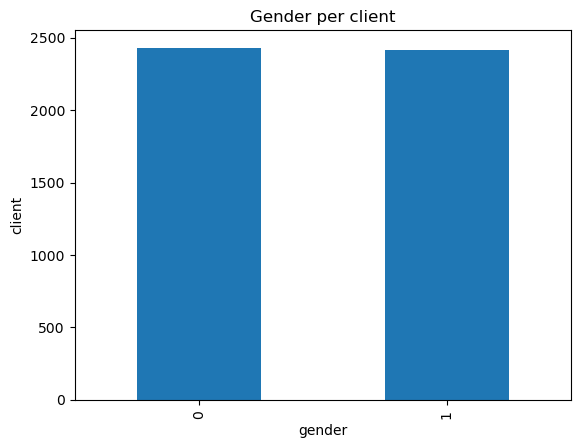

In [14]:
df.gender.value_counts().plot(kind='bar')
plt.title('Gender per client')
plt.ylabel('client')
plt.show()

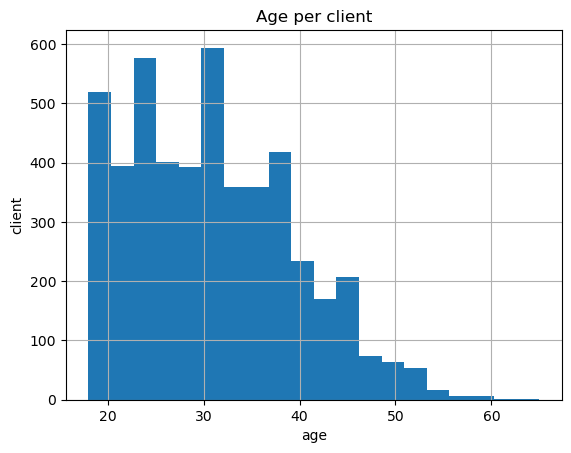

In [15]:
df.age.hist(bins=20)
plt.title('Age per client')
plt.xlabel('age')
plt.ylabel('client')
plt.show()

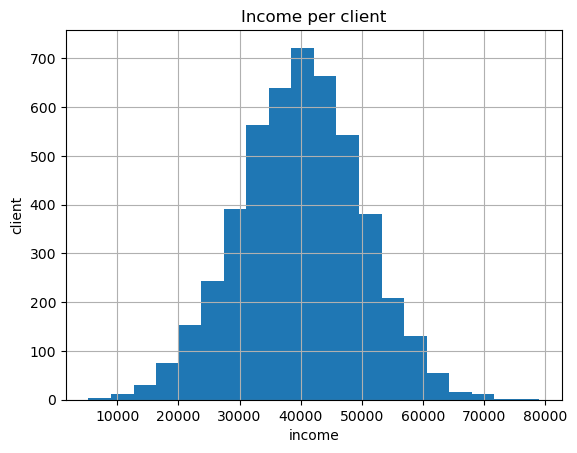

In [16]:
df.income.hist(bins=20)
plt.title('Income per client')
plt.xlabel('income')
plt.ylabel('client')
plt.show()

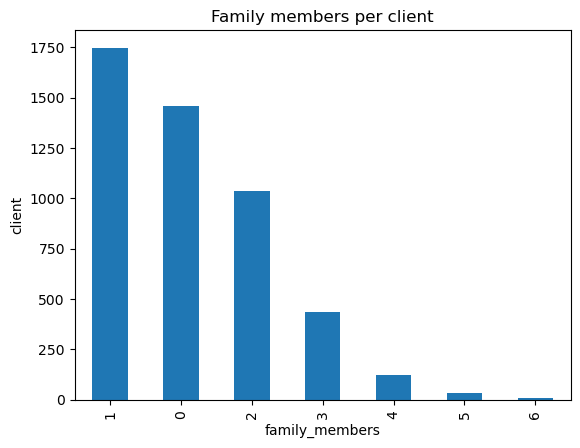

In [17]:
df.family_members.value_counts().plot(kind='bar')
plt.title('Family members per client')
plt.ylabel('client')
plt.show()

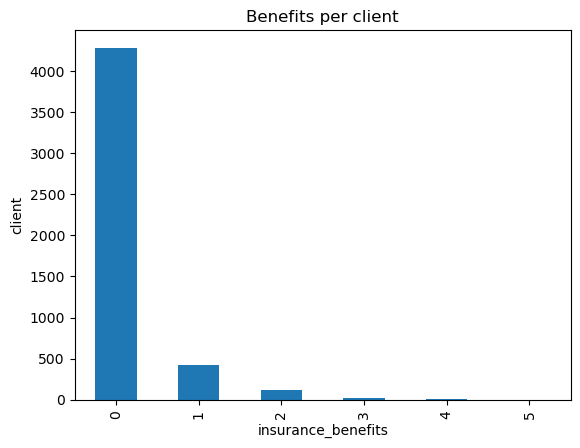

In [18]:
df.insurance_benefits.value_counts().plot(kind='bar')
plt.title('Benefits per client')
plt.ylabel('client')
plt.show()

Revisemos valores extremos en las variables `age` y `income`

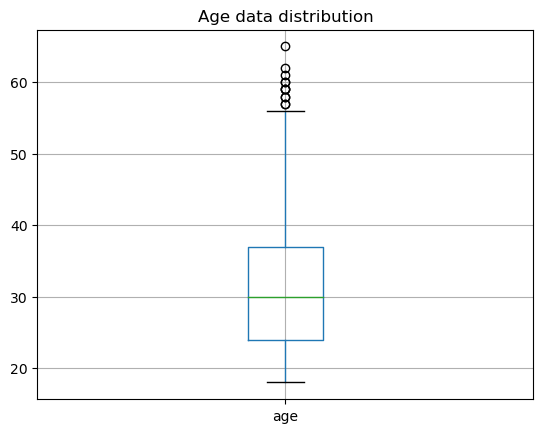

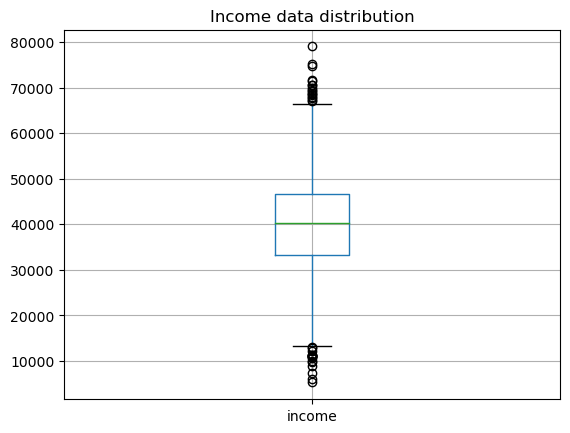

In [19]:
df[['age']].boxplot()
plt.title('Age data distribution')
plt.show()

df[['income']].boxplot()
plt.title('Income data distribution')
plt.show()

A continuación eliminaremos los valores extremos.

In [20]:
# "bounds" function to calculate upper and lower limits
def bounds(df, col):

    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lim_min = (Q1 - 1.5 * IQR).astype('int')
    lim_max = (Q3 + 1.5 * IQR).astype('int')

    return [lim_min, lim_max]
    # return a list with 2 values: lower and upper bound

# --------------------------------------------------------

# "outliers" function to find the indices of the outliers

def outliers(df, col):
    min, max = bounds(df, col)
    return df[(df[col] <= min) | (df[col] >= max)].index

# --------------------------------------------------------

# "clean_outliers" function to remove outliers

def clean_outliers(df, col):
    indexes = outliers(df, col)
    df.drop(indexes, inplace=True)


# Columns to clean
columns_selected = ['age', 'income']


In [21]:
# Eliminamos los outliers

total = len(df)
aux = 0

while True:
    # Remove outliers in each column
    for column in columns_selected:
        clean_outliers(df, column)

    total_df_clean = len(df)
    percent = (total - total_df_clean) / total

    # Exits when it can't be cleaned anymore
    if total_df_clean == aux:
        break
    else:
        aux = total_df_clean

print(f'removing outliers, total {percent:.2%} \n')

removing outliers, total 1.11% 



In [22]:
df.reset_index(inplace=True, drop=True)

In [23]:
df.head()

,gender,age,income,family_members,insurance_benefits
0,1,41,49600.0,1,0
1,0,46,38000.0,1,1
2,0,29,21000.0,0,0
3,0,21,41700.0,2,0
4,1,28,26100.0,0,0


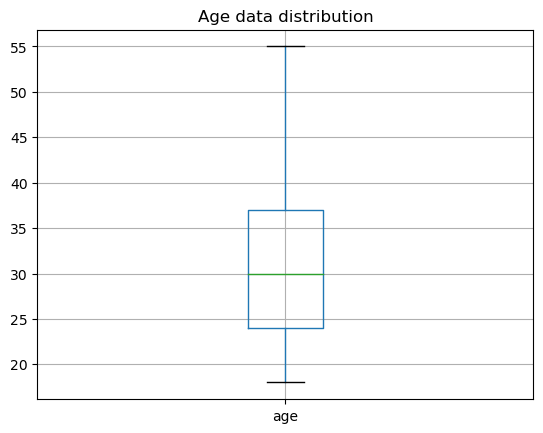

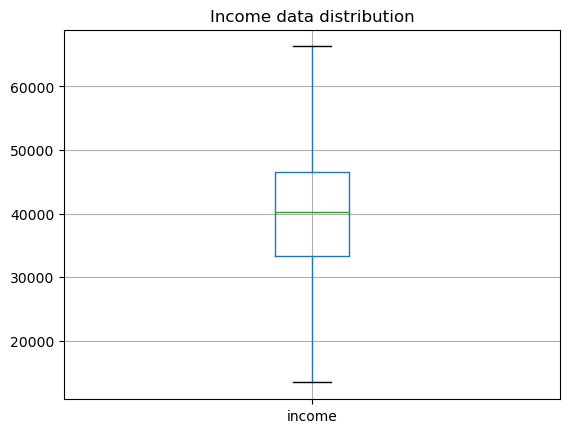

In [24]:
df[['age']].boxplot()
plt.title('Age data distribution')
plt.show()

df[['income']].boxplot()
plt.title('Income data distribution')
plt.show()

Hemos eliminado los outliers.

In [25]:
df.shape

(4793, 5)

# Tarea 1. Clientes similares

Escribiremos una función que devuelva los k vecinos más cercanos para un $n^{th}$ objeto basándose en una métrica de distancia especificada. A la hora de realizar esta tarea no debe tenerse en cuenta el número de prestaciones de seguro recibidas.

Pruébalo para cuatro combinaciones de dos casos- Escalado
  - los datos no están escalados
  - los datos escalados (escalador MaxAbsScaler)
- Métricas de distancia
  - Euclidiana
  - Manhattan

In [27]:
feature_names = ['gender', 'age', 'income', 'family_members']

In [28]:
def get_knn(df, n, k, metric_):
    
    """
    Devuelve los k vecinos más cercanos

    :param df: DataFrame de pandas utilizado para encontrar objetos similares dentro del mismo lugar    
    :param n: número de objetos para los que se buscan los vecinos más cercanos    
    :param k: número de vecinos más cercanos a devolver
    :param métrica: nombre de la métrica de distancia    """

    nbrs = NearestNeighbors(n_neighbors=n, metric=metric_).fit(df[feature_names].values)
    
    nbrs_distances, nbrs_indices = nbrs.kneighbors([df.iloc[n][feature_names]], k, return_distance=True)
    
    df_res = pd.concat([df.iloc[nbrs_indices[0]], 
                        pd.DataFrame(nbrs_distances.T, index=nbrs_indices[0], columns=['distance'])], 
                        axis=1)
    
    return df_res

Escalamos los datos:

In [29]:
feature_names = ['gender', 'age', 'income', 'family_members']
df_scaled = df.copy()

transformer_mas = MaxAbsScaler()
transformer_mas.fit(df[feature_names].to_numpy())
df_scaled[feature_names] = transformer_mas.transform(df[feature_names].to_numpy())

In [30]:
df_scaled.sample(5)

,gender,age,income,family_members,insurance_benefits
1050,1.0,0.490909,0.864253,0.000000,0
1985,0.0,0.618182,0.586727,0.333333,0
4403,0.0,0.418182,0.612368,0.166667,0
3703,1.0,0.563636,0.580694,0.000000,0
4389,0.0,0.654545,0.837104,0.333333,0


In [31]:
df_scaled.describe()

,gender,age,income,family_members,insurance_benefits
count,4793.000000,4793.000000,4793.000000,4793.000000,4793.000000
mean,0.497601,0.562146,0.602189,0.200709,0.140413
std,0.500046,0.151788,0.145533,0.183218,0.423265
min,0.000000,0.327273,0.202112,0.000000,0.000000
25%,0.000000,0.436364,0.502262,0.000000,0.000000
50%,0.000000,0.545455,0.606335,0.166667,0.000000
75%,1.000000,0.672727,0.702866,0.333333,0.000000
max,1.000000,1.000000,1.000000,1.000000,3.000000


Ahora, vamos a obtener registros similares para uno determinado, para cada combinación con: n = cliente al azar "2550" y k = 10 vecinos cercanos a encontrar.

4 Casos a probar:
- Caso 1: distancia Euclidean con datos no escalados
- Caso 2: distancia Manhattan con datos no escalados
- Caso 3: distancia Euclidean con datos escalados
- Caso 4: distancia Manhattan con datos escalados


In [32]:
# Caso 1
get_knn(df, 2550, 10, 'euclidean').distance

2550      0.000000
905       5.000000
3412     10.099505
2718     16.124515
4530     17.029386
1470    100.129916
625     100.737282
4476    100.851376
767     101.123687
3879    101.271911
Name: distance, dtype: float64

In [33]:
# Caso 2
get_knn(df, 2550, 10, 'cityblock').distance

2550      0.0
905       5.0
3412     12.0
2718     18.0
4530     18.0
1470    106.0
625     114.0
4476    115.0
3879    116.0
767     116.0
Name: distance, dtype: float64

In [34]:
# Caso 3
get_knn(df_scaled, 2550, 10, 'euclidean').distance

2550    0.000000
2118    0.021116
2704    0.024614
1826    0.045381
1921    0.054299
3420    0.060332
2417    0.063075
2476    0.071724
4477    0.073184
2573    0.073842
Name: distance, dtype: float64

In [35]:
# Caso 4
get_knn(df_scaled, 2550, 10, 'cityblock').distance

2550    0.000000
2118    0.021116
2704    0.034773
1921    0.054299
3420    0.060332
1826    0.063513
2207    0.081448
2417    0.086220
2476    0.087563
1027    0.088989
Name: distance, dtype: float64

Como observamos los 4 casos, pudimos obtener 10 vecinos cercanos del cliente con índice 2550, probando las distancias Euclideana y Manhattan (cityblock) en datos escalado y no escalados.

**¿El hecho de que los datos no estén escalados afecta al algoritmo kNN? Si es así, ¿cómo se manifiesta?** 

Las distancias que obtuvimos usando los datos no escalados son más grandes que las obtenidas desde los datos escalados, esto tiene sentido ya que los datos escalados están dentro del rango 0 a 1.

**¿Qué tan similares son los resultados al utilizar la métrica de distancia Manhattan (independientemente del escalado)?** 

Los vecinos que encontramos usando la distancia Manhattan son diferentes tanto desde los datos no escalados como desde los escalados. No existen coincidencia.

# Tarea 2. ¿Es probable que el cliente reciba una prestación del seguro?

Evaluaremos si el enfoque de clasificación K-Nearest-Neighbor puede funcionar mejor un modelo dummy. Toma en cuenta lo siguiente:

- El objetivo es el valor de `insurance_benefits` superior a cero.
- Construye un modelo clasificador basado en KNN. Mide su calidad con la métrica F1 para k=1...10 tanto para los datos originales como para los datos  escalados. 
- Observaremos cómo k puede influir en la métrica de evaluación y si el escalado de los datos provoca alguna diferencia.
- El modelo dummy debería devolver "1" con cierta probabilidad. Probemos el modelo con cuatro valores de probabilidad: 0, la probabilidad de pagar cualquier prestación del seguro, 0.5, 1.
- Divide todos los datos correspondientes a las etapas de entrenamiento/prueba respetando la proporción 70:30.

Crearemos una columna adicional `insurance_benefits_received` para establecer si un cliente recibe o no una prestación de seguro, basándonos en la columna `insurance_benefits`.

In [36]:
# сalcula el objetivo
df['insurance_benefits_received']        =        df['insurance_benefits'] > 0
df_scaled['insurance_benefits_received'] = df_scaled['insurance_benefits'] > 0

In [37]:
df.sample(5)

,gender,age,income,family_members,insurance_benefits,insurance_benefits_received
432,1,27,41300.0,1,0,False
1371,0,37,21700.0,1,0,False
4142,1,30,24100.0,1,0,False
1886,1,33,33200.0,1,0,False
2516,1,45,51000.0,2,1,True


In [38]:
df_scaled.sample(5)

,gender,age,income,family_members,insurance_benefits,insurance_benefits_received
459,0.0,0.600000,0.387632,0.500000,0,False
1230,1.0,0.618182,0.598793,0.333333,0,False
1495,1.0,0.563636,0.360483,0.166667,0,False
916,0.0,0.727273,0.778281,0.000000,0,False
2225,1.0,0.727273,0.619910,0.000000,0,False


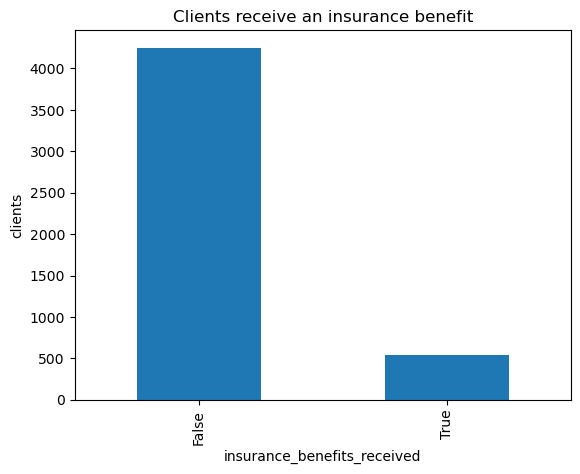

In [39]:
# comprueba el desequilibrio de clases con value_counts()

df.insurance_benefits_received.value_counts().plot(kind='bar')
plt.title('Clients receive an insurance benefit')
plt.ylabel('clients')
plt.show()

Podemos notar que existe un desequilibrio de clase para `insurance_benefits_received`. Más adelante probaremos nuestro modelo con las clases equilibradas.

## 1-Modelo dummy

Crearemos un modelo aleatorio. Debería devolver "1" con cierta probabilidad. Probaremos el modelo con 4 valores de probabilidad: a) 0, b) probabilidad de pagar cualquier prestación del seguro, c) 0.5 y d) 1. 

La probabilidad de pagar cualquier prestación del seguro puede definirse como

$
P\{\text{prestación de seguro recibida}\}=\frac{\text{número de clientes que han recibido alguna prestación de seguro}}{\text{número total de clientes}}.
$

Mediremos calidad con F1.

In [40]:
# Función para evaluar el clasificador

def eval_classifier(y_true, y_pred):
    
    f1_score = sklearn.metrics.f1_score(y_true, y_pred)
    print(f'F1: {f1_score:.2f}')
    
    cm = confusion_matrix(y_true, y_pred, normalize='all')
    cm = np.round(cm, decimals=2)
    print('Matriz de confusión:')
    print(cm)

In [41]:
# generar la salida de un modelo aleatorio

def rnd_model_predict(P, size, seed=42):

    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

Obtenidas nuestras funciones las usaremos para ejecutar nuestro modelo aletarorio de acuerdo a las 4 probabilidades que definimos:

In [42]:
pr = df['insurance_benefits_received'].sum() / len(df)

for P in [0, pr, 0.5, 1]:

    print(f'La probabilidad: {P:.2f}')
    y_pred_rnd = rnd_model_predict(P, len(df))
    
    eval_classifier(df['insurance_benefits_received'], y_pred_rnd)
    
    print()

La probabilidad: 0.00
F1: 0.00
Matriz de confusión:
[[0.89 0.  ]
 [0.11 0.  ]]

La probabilidad: 0.11
F1: 0.10
Matriz de confusión:
[[0.79 0.1 ]
 [0.1  0.01]]

La probabilidad: 0.50
F1: 0.18
Matriz de confusión:
[[0.45 0.44]
 [0.06 0.05]]

La probabilidad: 1.00
F1: 0.20
Matriz de confusión:
[[0.   0.89]
 [0.   0.11]]



Podemos observar que ha medida que aumentamos el umbral de probabilidad, las respuestas de la clase positiva "1" aumentarán; podemos confirmar esto mirando como nuestra métrica F1 aumenta su valor indicando que, a mayor probabilidad mejora la calidad del modelo.

## 2-Modelo Clasificador K-NN

Construiremos un clasificador basado en KNN y mediremos su calidad con la métrica F1 para k=1...10 tanto para los datos originales como para los escalados.

In [43]:
# Función para segmentar de datos en entrenamiento y prueba 70:30

def split_data(df):
    features = df.drop(['insurance_benefits_received', 'insurance_benefits'], axis=1)
    target = df['insurance_benefits_received']

    X_train, X_test, y_train, y_test = train_test_split(features,
                                                        target,
                                                        test_size=0.30,
                                                        random_state=12345)
    
    # para revisar tamaños descomenta la siguiente linea
    # print(f'Size train data X={X_train.shape}, y={y_train.shape}\nSize train data X={X_test.shape}, y={y_test.shape}')

    return X_train, X_test, y_train, y_test 

In [44]:
# Clasificador k-Nearest Neighbor con datos sin escalar y escalados

dataset = {'Unscaled data':df, 'Scaled data':df_scaled}

scores_summary = pd.DataFrame(index=[1,2,3,4,5,6,7,8,9,10])

for name, data in dataset.items():
    
    # Segmentar datos
    X_train, X_test, y_train, y_test = split_data(data)
    
    print(f'\n{name}:')

    vector_score = []
    for n_neighbors in range(1,11):
        knn = KNeighborsClassifier(n_neighbors)
        knn.fit(X_train, y_train)
        predict = knn.predict(X_test)
        score = f1_score(y_test, predict)
        
        print(f'F1 score with {n_neighbors} neighbors {score:.2f}')
        vector_score.append(score)

    scores_summary[name+'_f1'] = vector_score


Unscaled data:
F1 score with 1 neighbors 0.62
F1 score with 2 neighbors 0.30
F1 score with 3 neighbors 0.33
F1 score with 4 neighbors 0.16
F1 score with 5 neighbors 0.19
F1 score with 6 neighbors 0.05
F1 score with 7 neighbors 0.05
F1 score with 8 neighbors 0.02
F1 score with 9 neighbors 0.02
F1 score with 10 neighbors 0.01

Scaled data:
F1 score with 1 neighbors 0.95
F1 score with 2 neighbors 0.91
F1 score with 3 neighbors 0.91
F1 score with 4 neighbors 0.89
F1 score with 5 neighbors 0.90
F1 score with 6 neighbors 0.88
F1 score with 7 neighbors 0.89
F1 score with 8 neighbors 0.87
F1 score with 9 neighbors 0.90
F1 score with 10 neighbors 0.86


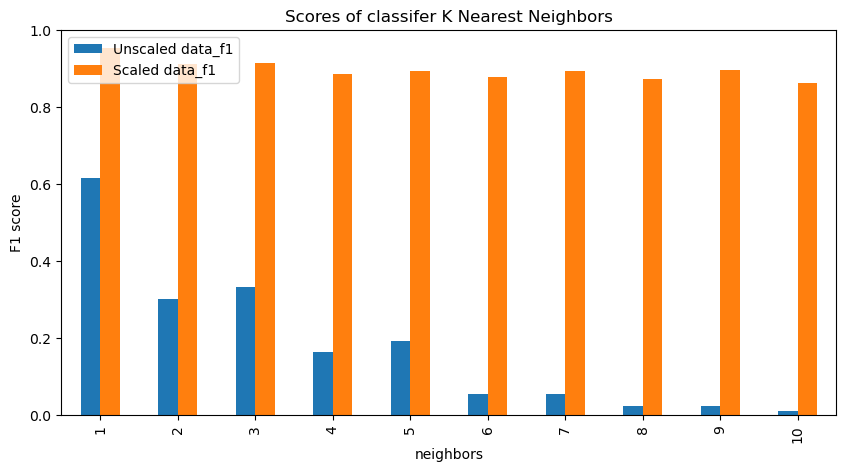

In [45]:
# Graficamos los scores

scores_summary.plot(kind='bar', figsize=(10,5))
plt.xlabel('neighbors')
plt.ylabel('F1 score')
plt.title('Scores of classifer K Nearest Neighbors')
plt.show()

Hemos obtenido los score F1 de nuestro clasificador para el conjunto de datos sin escalar y para el conjunto de datos escalados. 

En los resultados con datos no escalados, podemos observar una calidad muy baja de nuestro modelo y podemos ver claramente entre más vecinos nuestro algoritmo KNN tiene peor calidad. Por otro lado los score calculados con la data escalada no decrecen ni crecen, se mantienen sobre el un score F1 de 0.86, lo cual nos proporciona una mejor calidad.


A continuación realizaremos este mismo modelo con la diferencia que vamos a equilibrar nuestras clases que estan desequilibradas, y podremos saber si este es un factor que nos ayudaría a mejorar la calidad de nuestro modelo clasificador.

In [46]:
# Función submuestreo

def downsample(features, target, fraction):

    # Dividir el conjunto de datos de entrenamiento en observaciones negativas y positivas
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    # Soltar al azar una parte de las observaciones negativas
    # Crear una nueva muestra de entrenamiento basada en los datos obtenidos después de la caída
    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled   = pd.concat([  target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])

    # Mezclar los datos. Asegúrate de que los datos positivos no sigan a los negativos: esto dificultará que los algoritmos aprendan.
    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state=12345)

    return features_downsampled, target_downsampled

#----------------------------------------------

In [47]:
# balanceamos los datos de entrenamiento con el sobremuestreo

X_train, X_test, y_train, y_test = split_data(df)

X_upsampled, y_upsampled = downsample(X_train, y_train, 0.1)

print(f'         Train dataset: features={X_train.shape},  target={y_train.shape}')
print(f'Train balanced dataset: features={X_upsampled.shape}, target={y_upsampled.shape}')

         Train dataset: features=(3355, 4),  target=(3355,)
Train balanced dataset: features=(666, 4), target=(666,)


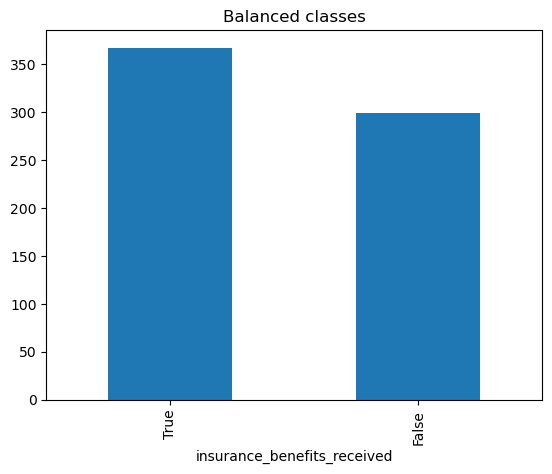

In [48]:
# comprueba el equilibrio de clases con value_counts()

y_upsampled.value_counts().plot(kind='bar')
plt.title('Balanced classes')
plt.show()

Ahora probaremos el modelo clasificador KNN con clases equilibradas:

In [49]:
# Clasificador k-Nearest Neighbor

dataset = {'Balanced Unscaled data':df, 'Balanced Scaled data':df_scaled}

for name, data in dataset.items():
    
    # Segmentar datos
    X_train, X_test, y_train, y_test = split_data(data)

    # Equilibramos las clases
    X_train, y_train = downsample(X_train, y_train, 0.1)
    X_test, y_test = downsample(X_train, y_train, 0.1)
    
    print(f'\n{name}:')

    vector_score = []
    for n_neighbors in range(1,11):
        knn = KNeighborsClassifier(n_neighbors)
        knn.fit(X_train, y_train)
        predict = knn.predict(X_test)
        score = f1_score(y_test, predict)
        
        print(f'F1 score with {n_neighbors} neighbors {score:.2f}')
        vector_score.append(score)

    scores_summary[name+'_f1'] = vector_score


Balanced Unscaled data:
F1 score with 1 neighbors 1.00
F1 score with 2 neighbors 0.86
F1 score with 3 neighbors 0.94
F1 score with 4 neighbors 0.84
F1 score with 5 neighbors 0.90
F1 score with 6 neighbors 0.84
F1 score with 7 neighbors 0.89
F1 score with 8 neighbors 0.84
F1 score with 9 neighbors 0.89
F1 score with 10 neighbors 0.83

Balanced Scaled data:
F1 score with 1 neighbors 1.00
F1 score with 2 neighbors 0.99
F1 score with 3 neighbors 1.00
F1 score with 4 neighbors 1.00
F1 score with 5 neighbors 1.00
F1 score with 6 neighbors 1.00
F1 score with 7 neighbors 1.00
F1 score with 8 neighbors 1.00
F1 score with 9 neighbors 1.00
F1 score with 10 neighbors 1.00


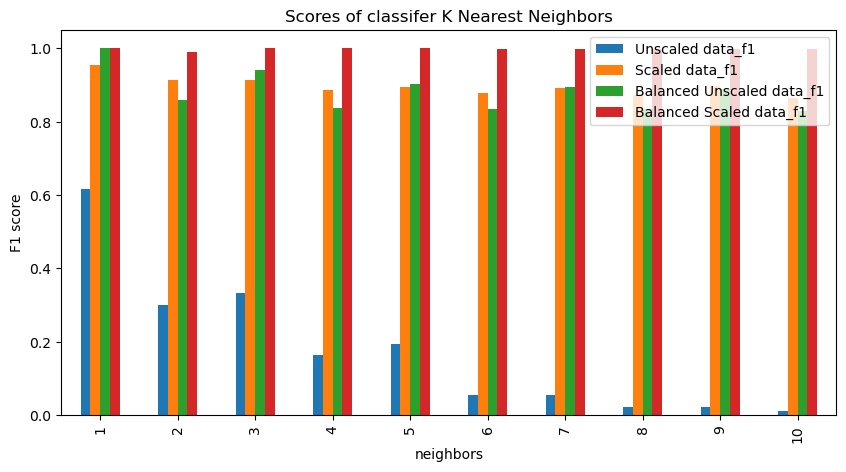

In [50]:
# Graficamos los scores

scores_summary.plot(kind='bar', figsize=(10,5))
plt.xlabel('neighbors')
plt.ylabel('F1 score')
plt.title('Scores of classifer K Nearest Neighbors')
plt.show()

Podemos notar alta calidad en nuestro, el escalado de datos mejoró las métricas, pero el equilibrio de las clases mejoró más significativamente, las métricas son perfectas!. 

Nuestro modelo entrenado lo hace mejor que el modelo aleatorio.

# Tarea 3. Regresión lineal

Con `insurance_benefits` como objetivo, evalúa cuál sería la RECM de un modelo de regresión lineal.

Construiremos una implementación de regresión lineal. Para ello, recuerdaremos cómo está formulada la solución de la tarea de regresión lineal en términos de LA. Compruebaremos la RECM tanto para los datos originales como para los escalados. ¿Podemos ver alguna diferencia en la RECM con respecto a estos dos casos?

Denotemos
- $X$: matriz de características; cada fila es un caso, cada columna es una característica, la primera columna está formada por unidades
- $y$ — objetivo (un vector)
- $\hat{y}$ — objetivo estimado (un vector)
- $w$ — vector de pesos

La tarea de regresión lineal en el lenguaje de las matrices puede formularse así:
$$
y = Xw
$$

El objetivo de entrenamiento es entonces encontrar esa $w$ que minimice la distancia L2 (ECM) entre $Xw$ y $y$:

$$
\min_w d_2(Xw, y) \quad \text{or} \quad \min_w \text{MSE}(Xw, y)
$$

Parece que hay una solución analítica para lo anteriormente expuesto:
$$
w = (X^T X)^{-1} X^T y
$$

La fórmula anterior puede servir para encontrar los pesos $w$ y estos últimos pueden utilizarse para calcular los valores predichos
$$
\hat{y} = X_{val}w
$$

Dividiremos todos los datos correspondientes a las etapas de entrenamiento/prueba respetando la proporción 70:30. Utilizaremos la métrica RECM para evaluar el modelo.

In [51]:
class MyLinearRegression:
    
    def __init__(self):
        self.weights = None
    
    def fit(self, X, y):
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        weights = np.linalg.inv(X2.T.dot(X2)).dot(X2.T).dot(y)
        self.weights  = weights[1:]
        self.w0 = weights[0]

    def predict(self, X):
        y_pred = X.dot(self.weights) + self.w0
        return y_pred

In [52]:
def eval_regressor(y_true, y_pred):
    
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    print(f'RMSE: {rmse:.2f}')
    
    r2 = math.sqrt(r2_score(y_true, y_pred))
    print(f'R2: {r2:.2f}')    

In [53]:
# Función para segmentar de datos en entrenamiento y prueba 70:30

def split_data_rl(df):
    features = df.drop(['insurance_benefits_received', 'insurance_benefits'], axis=1)
    target = df['insurance_benefits']

    X_train, X_test, y_train, y_test = train_test_split(features,
                                                        target,
                                                        test_size=0.30,
                                                        random_state=12345)
    return X_train, X_test, y_train, y_test 

In [54]:
# Linear Regression

dataset = {'Unscaled data':df, 'Scaled data':df_scaled}

for name, data in dataset.items():
    
    # Segmentar datos
    X_train, X_test, y_train, y_test = split_data_rl(data)
    print(f'\n{name}:')

    lr = MyLinearRegression()
    lr.fit(X_train, y_train)
    y_test_pred = lr.predict(X_test)
    
    print('- Predictions:')
    print(y_test.tail())
    
    print()
    print(f'- Weights {lr.weights}\n')
    print('- Scores:')
    
    eval_regressor(y_test, y_test_pred)


Unscaled data:
- Predictions:
1098    0
2464    1
1885    0
524     0
4398    0
Name: insurance_benefits, dtype: int64

- Weights [-3.01335073e-04  3.24187284e-02 -3.30737899e-07 -1.25380128e-02]

- Scores:
RMSE: 0.33
R2: 0.66

Scaled data:
- Predictions:
1098    0
2464    1
1885    0
524     0
4398    0
Name: insurance_benefits, dtype: int64

- Weights [-3.01335073e-04  1.78303006e+00 -2.19279227e-02 -7.52280766e-02]

- Scores:
RMSE: 0.33
R2: 0.66


Hemos entrenado nuestro modelo de Regresion Lineal con los datos escalados y sin escalar. 

El cálculo de los pesos nos indica que hay variables más fuertes que otras, y las métricas no varían en cada caso se obtuvo los scores RMSE 0.33 y el R2 de 0.66. En ambos casos se puede mejorar.

# Tarea 4. Ofuscar datos

Vamos a ofuscar los datos multiplicando las características numéricas (recuerda que se pueden ver como la matriz $X$) por una matriz invertible $P$. 

$$
X' = X \times P
$$

Compruebaremos cómo quedarán los valores de las características después de la transformación. Asegúrate de que $P$ sea realmente invertible.

In [55]:
personal_info_column_list = ['gender', 'age', 'income', 'family_members']
df_pn = df[personal_info_column_list]

In [56]:
X = df_pn.to_numpy()
np.set_printoptions(suppress=True) # Suprime notación cientifica para datos manejados por numpy
X

array([[    1.,    41., 49600.,     1.],
       [    0.,    46., 38000.,     1.],
       [    0.,    29., 21000.,     0.],
       ...,
       [    0.,    20., 33900.,     2.],
       [    1.,    22., 32700.,     3.],
       [    1.,    28., 40600.,     1.]])

Generar una matriz aleatoria $P$.

In [57]:
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))

Comprobar que la matriz P sea invertible

In [58]:
np.linalg.inv(P) @ P

array([[ 1., -0., -0., -0.],
       [ 0.,  1.,  0., -0.],
       [-0.,  0.,  1.,  0.],
       [ 0., -0., -0.,  1.]])

Podemos verificar que nuestra matriz P es una matriz invertible, puesto que obtuvimos una matriz de identidad del producto de la matriz P invertida con P: 

$P^{-1} P$ = I

¿Puedes adivinar la edad o los ingresos de los clientes después de la transformación?

In [59]:
# Transformamos mediante la ofuscación nuestros datos
XP = np.dot(X, P)
XP

array([[ 6359.71527314, 22380.40467609, 18424.09074184, 46000.69669016],
       [ 4873.29406479, 17160.36702982, 14125.78076133, 35253.45577301],
       [ 2693.11742928,  9486.397744  ,  7808.83156024, 19484.86063067],
       ...,
       [ 4346.2234249 , 15289.24126492, 12586.16264392, 31433.50888552],
       [ 4194.09324155, 14751.9910242 , 12144.02930637, 30323.88763426],
       [ 5205.46827354, 18314.24814446, 15077.01370762, 37649.59295455]])

- Después de la transformación los datos se ven enmascarados, no se logran adivinar características de los clientes.

¿Puedes recuperar los datos originales de $X'$ si conoces $P$? Intenta comprobarlo a través de los cálculos moviendo $P$ del lado derecho de la fórmula anterior al izquierdo. En este caso las reglas de la multiplicación matricial son realmente útiles

In [60]:
recovered = np.dot(XP, np.linalg.inv(P))
recovered

array([[    1.,    41., 49600.,     1.],
       [   -0.,    46., 38000.,     1.],
       [    0.,    29., 21000.,     0.],
       ...,
       [    0.,    20., 33900.,     2.],
       [    1.,    22., 32700.,     3.],
       [    1.,    28., 40600.,     1.]])

Hemos obtenido los valores originales de X realizando la multiplicación de $X'$ con la inversa de $P$.

Muestra los tres casos para algunos clientes, ejemplo los clientes con indice 1 y 2.
- Datos originales
- El que está transformado
- El que está invertido (recuperado)

In [61]:
# Cliente con index 1 y 2

# datos original
print('1- Original data')
print(df_pn.iloc[[1,2]])

print('\n2- Obfuscated data')
# Transformado
print(XP[1:3])

# Recuperado
print('\n3- Recovered data')
print(np.round(recovered[1:3], decimals=2))

1- Original data
   gender  age   income  family_members
1       0   46  38000.0               1
2       0   29  21000.0               0

2- Obfuscated data
[[ 4873.29406479 17160.36702982 14125.78076133 35253.45577301]
 [ 2693.11742928  9486.397744    7808.83156024 19484.86063067]]

3- Recovered data
[[   -0.    46. 38000.     1.]
 [    0.    29. 21000.     0.]]


Seguramente puedes ver que algunos valores no son exactamente iguales a los de los datos originales. ¿Cuál podría ser la razón de ello?

- Los datos son los mismos después de la recuperación, vemos variaciones del formato con el 0 negativo. Esto puede deberse a que numpy usa transformación científica a los datos.

## Prueba de que la ofuscación de datos puede funcionar con regresión lineal

En este proyecto la tarea de regresión se ha resuelto con la regresión lineal. Vamos a demostrar analíticamente que el método de ofuscación no afectará a la regresión lineal en términos de valores predichos, es decir, que sus valores seguirán siendo los mismos.

Entonces, los datos están ofuscados y ahora tenemos $X \times P$ en lugar de tener solo $X$. En consecuencia, hay otros pesos $w_P$ como
$$
w = (X^T X)^{-1} X^T y \quad \Rightarrow \quad w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

*¿Cómo se relacionarían $w$ y $w_P$ si simplificáramos la fórmula de $w_P$ anterior?*

Veamos como están realacionadas $w$ y $w_P$ simplificando la fórmula de $w_P$. Mostraremos el paso a paso usando las propiedades de las matrices:

$$
w_P = ((XP)^T XP)^{-1} (XP)^T y 
$$

1. Aplicando $(𝐴𝐵)^𝑇 = 𝐵^𝑇𝐴^𝑇$ entonces,

$$
w_P = (P^T X^T XP)^{-1} P^T X^T y
$$

2. Luego $(𝐴𝐵)^{-1} = 𝐵^{-1} 𝐴^{-1}$ entonces,

$$
w_P = P^{-1} X^{-1} (X^T)^{-1} (P^T)^{-1} P^T X^T y
$$

3. Con $A^{-1}A = AA^{-1} = I$, y $ IA = A$ y $AI = A$ entonces,

$$
w_P = P^{-1} X^{-1} (X^T)^{-1} I X^T y
$$

$$
w_P = P^{-1} X^{-1} (X^T)^{-1} X^T y
$$

4. Entonces volvemos a $B^T A^T = (AB)^T$

$$
w_P = P^{-1} (X^T X)^{-1} X^T y
$$

5. Tenemos finalmente que,

$$
w_P = P^{-1} w
$$

$w_P$ y $w$ están relacionadas, $w_P$ es igual al producto de la matriz P inversa y los pesos w originales.

**Prueba analítica**

*¿Cuáles serían los valores predichos con $w_P$?*

El cálculo de valores predichos usando regresión lineal se representaría así: $ \hat{y} = Xw $

En la ofuscación de datos $X$ se representa como $XP$ y los pesos $w$ serán representados $w_P$, entonces tenemos que:

$$
\hat{y}_P = XPw_P 
$$

Aplicamos $w_P$ = $P^{-1}w$
$$
\hat{y}_P = XPP^{-1}w
$$

Aplicamos $PP^{-1}$ = $I$
$$
\hat{y}_P = XIw
$$

$$
\hat{y}_P = Xw
$$

$$
\hat{y}_P = \hat{y}
$$

Como resultado tenemos que, los valores predichos con los pesos $w_P$ serán iguales que los valores predichos que calculemos con $w$. Es decir, las predicciones que calculemos con los pesos de los valores originales o con los pesos de los valores ofuscados, no variarán.

*¿Qué significa esto para la calidad de la regresión lineal si esta se mide mediante la RECM?*

Partiendo de la demostración de que $ \hat{y}_P = \hat{y} $ es decir, los valores predichos no cambiarán tanto si usamos valores originales o si usamos valores ofuscados, por ende, nuestras métricas RECM se mantendrán iguales. 

A continuación realizaremos el entrenamiento del modelo de regresión lineal y comprobaremos esta prueba analítica.

## Prueba de regresión lineal con ofuscación de datos

Ahora, probemos que la regresión lineal pueda funcionar, en términos computacionales, con la transformación de ofuscación elegida.
Construye un procedimiento o una clase que ejecute la regresión lineal opcionalmente con la ofuscación. Puedes usar una implementación de regresión lineal de scikit-learn o tu propia implementación.
Ejecuta la regresión lineal para los datos originales y los ofuscados, compara los valores predichos y los valores de las métricas RMSE y $R^2$. ¿Hay alguna diferencia?

**Procedimiento**

- Crea una matriz cuadrada $P$ de números aleatorios.- Comprueba que sea invertible. Si no lo es, repite el primer paso hasta obtener una matriz invertible.- <¡ tu comentario aquí !>
- Utiliza $XP$ como la nueva matriz de características

In [62]:
def obfuscation(df, columns_name):

    X = df[columns_name].to_numpy()
    np.set_printoptions(suppress=True) # Suprime notación cientifica para datos manejados por numpy
 
    # genera P, una matriz aleatoria
    rng = np.random.default_rng(seed=42)
    P = rng.random(size=(X.shape[1], X.shape[1]))
    
    # Transformamos mediante la ofuscación nuestros datos
    XP = np.dot(X, P)
    XP_data = pd.DataFrame(XP, columns=[columns_name], index=df.index)
    return XP_data

In [63]:
class MyLinearRegression:
    
    def __init__(self, ):
        self.weights = None
    
    def fit(self, X, y):
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        weights = np.linalg.inv(X2.T.dot(X2)).dot(X2.T).dot(y)
        self.weights  = weights[1:]
        self.w0 = weights[0]

    def predict(self, X):
        y_pred = X.dot(self.weights) + self.w0
        return y_pred

In [64]:
def eval_regressor(y_true, y_pred):
    
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    print(f'RMSE: {rmse:.2f}')
    
    r2 = math.sqrt(r2_score(y_true, y_pred))
    print(f'R2: {r2:.2f}')    

In [65]:
# Linear Regression 

feature_names = ['gender', 'age', 'income', 'family_members']

for name in ['Original', 'Obfuscation']:
    
    # Segmentar datos
    X_train, X_test, y_train, y_test = split_data_rl(df)
    
    if name == 'Obfuscation':
        X_train = obfuscation(X_train, feature_names)
        X_test = obfuscation(X_test, feature_names)
    
    print(f'\n{name} data:')

    lr = MyLinearRegression()
    lr.fit(X_train, y_train)
    y_test_pred = lr.predict(X_test)
    
    print('- Predictions:')
    print(y_test.tail())
    
    print()
    print(f'- Weights {lr.weights}\n')
    print('- Scores:')
    
    eval_regressor(y_test, y_test_pred)



Original data:
- Predictions:
1098    0
2464    1
1885    0
524     0
4398    0
Name: insurance_benefits, dtype: int64

- Weights [-0.00030134  0.03241873 -0.00000033 -0.01253801]

- Scores:
RMSE: 0.33
R2: 0.66

Obfuscation data:
- Predictions:
1098    0
2464    1
1885    0
524     0
4398    0
Name: insurance_benefits, dtype: int64

- Weights [-0.06103159 -0.00019323  0.07086219 -0.01982151]

- Scores:
RMSE: 0.33
R2: 0.66


Hemos entrenado nuestro modelo de regresion lineal con datos originales y datos ofuscaods. 

Notamos que los pesos de cada variable independiente varian. Sin embargo nuestras métricas varian puesto que las predicciones son iguales. Trabajar con los datos ofuscados no afecta la calidad del modelo.

# Conclusiones

- Dando inicio a este proyecto, se prepararon los datos originales, eliminando el 0.03% registros duplicados y el 1,11% valores extremos en la columna edad y income. 

- Se encontraron clientes similares de un cliente dado usando algoritmos de `Euclideana` y `Manhattan`. Las distancias calculadas de los clientes más similares cambian en base a si los datos están o no escalados. Saber estos los clientes similares de alguno en específico, ayudará a los agentes de la compañía con el marketing.

- Con el fin de predecir si un cliente recibe o no al menos una prestación del seguro, se entrenaron varios modelos de clasificación; usamos como algoritmo a `K'NeighborsClassifier`. Se obtuvo que el mejor modelo usando datos escalados y clases equilibradas. Además pudimos comprobar que nuestro modelo es mucho mejor que un simple modelo aleatorio.

- Construimos un modelo de regresión lineal para predecir el número de beneficios que contrató un cliente `insurance_benefits`. Comprobamos que tanto para los datos originales como para los escalados las métricas no varían obteniendo un RMSE 0.33 y el R2 de 0.66. En ambos casos se puede mejorar.

- Finalmente, pudimos hacer un análisis para demostrar si al ofuscar los datos cambiaría o no la calidad del modelo predictivo. Realizamos este análisis acompañado de una prueba analítica y se comprobó mediante el entrenamiento de un modelo de regresión lineal con datos originales y ofuscados, obteniendo como conclusión que, la ofuscación no cambian la calidad de nuestro modelo, las métricas se mantienen iguales tanto para los datos originales como para los datos enmascarados.